# Setup Environment

In [ ]:
pip install shap

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from numpy.random import randint
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import io
from google.colab import files
from google.colab import drive

from sklearn.inspection import permutation_importance
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from collections import defaultdict
import shap

from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

In [ ]:
import joblib

# Data Inputs Import

## Single sets
Note: Upload files from 'TMSA files for random forests' into temporary runtime storage via left window.

Files --> Upload to session storage

In [ ]:
#Trial level data
data_original = pd.read_excel('/content/TMSA_CILT_bl_DataLong_NounAcc_only_gen_train.xlsx')
data_original.head()
np.shape(data_original)

(4620, 7)

In [ ]:
#Network Features
nets_all = pd.read_excel('/content/Network_Strength_Set_3_gen_train.xlsx')
np.shape(nets_all)

(35, 84)

In [ ]:
# Linguistic Priors
ling = pd.read_excel('/content/Linguistics_Dataset_2_generalization_train.xlsx')
ling.head(0)
np.shape(ling)

(66, 8)

In [ ]:
# Clinical Data
clin = pd.read_excel('/content/Clinical_Dataset_1_generalization_train.xlsx')
np.shape(clin)

(35, 20)

Important: Key below

In [ ]:
# combine data_original with each one, inner join
data_clin = pd.merge(data_original,clin, on=["SubjID"])
data_ling = pd.merge(data_original,ling,on=["Agent_Noun"])
data_nets_all = pd.merge(data_original,nets_all, on=["SubjID"])


In [ ]:
print(np.shape(data_clin))
print(np.shape(data_ling))
print(np.shape(data_nets_all))

(4620, 26)
(4620, 14)
(4620, 90)


In [ ]:
# Check y is the same order for all
print(np.sum(data_original[['Noun_Acc']] != data_clin[['Noun_Acc']]))
print(np.sum(data_original[['Noun_Acc']] != data_ling[['Noun_Acc']]))
print(np.sum(data_original[['Noun_Acc']] != data_nets_all[['Noun_Acc']]))

Noun_Acc    0
dtype: int64
Noun_Acc    0
dtype: int64
Noun_Acc    0
dtype: int64


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [ ]:
# make y with log RT and for X dropping responses vars, irrelevant columns
y = data_original[['Noun_Acc']]
y = y.values.flatten()
len(y)

4620

In [ ]:
X_clin = data_clin.drop(['SubjID','Baseline', 'Trial', 'Card', 'Agent_Noun','Noun_Acc','Item_Type','WAB_AQ_1','WAB_AQ_2','log10_lesion_vol'], axis=1)

#changing categoricals to binary for addressing error - this goes alphabetically
le_sex = LabelEncoder()
X_clin["Sex"] = le_sex.fit_transform(X_clin['Sex'])

le_race = LabelEncoder()
X_clin["Race"] = le_race.fit_transform(X_clin['Race'])
X_clin.head()

le_eth = LabelEncoder()
X_clin["Ethnicity "] = le_eth.fit_transform(X_clin['Ethnicity '])

le_hand = LabelEncoder()
X_clin["Handed"] = le_hand.fit_transform(X_clin['Handed'])

le_class = LabelEncoder()
X_clin["Aphasia_Type_1"] = le_class.fit_transform(X_clin['Aphasia_Type_1'])

X_clin.head()


,MPO,Yrs Edu,Age,Travel solo,Sex,Race,Ethnicity,Handed,CCRSA,SS_WAB_Avg,AVC_WAB_Avg,NWF_WAB_Avg,Diff_WAB_AQ,Avg_WAB_AQ,Aphasia_Type_1,Lesion_Volume
0,98.815977,12,55.256325,1,1,4,1,2,22,12.0,9.625,8.95,0.7,76.8,1,100465
1,98.815977,12,55.256325,1,1,4,1,2,22,12.0,9.625,8.95,0.7,76.8,1,100465
2,98.815977,12,55.256325,1,1,4,1,2,22,12.0,9.625,8.95,0.7,76.8,1,100465
3,98.815977,12,55.256325,1,1,4,1,2,22,12.0,9.625,8.95,0.7,76.8,1,100465
4,98.815977,12,55.256325,1,1,4,1,2,22,12.0,9.625,8.95,0.7,76.8,1,100465


In [ ]:
np.shape(X_clin)

(4620, 16)

In [ ]:
# no missing values
X_clin.isna().sum().sum()

0

In [ ]:
# Only the sensible predictors - both ling + stroke here in X
# also remove columns that have details of Randomization and the Classification column directly
X_ling = data_ling.drop(['SubjID','Baseline', 'Trial', 'Agent_Noun','Noun_Acc','Item_Type', 'Card'], axis=1)

#changing categoricals to binary for addressing error - this goes alphabetically
le_freq = LabelEncoder()
X_ling["Freq_Cond"] = le_freq.fit_transform(X_ling['Freq_Cond']) #HI = 0, LO = 1

le_NA = LabelEncoder()
X_ling["NA_Cond"] = le_NA.fit_transform(X_ling['NA_Cond']) #HI = 0, LO = 1
X_ling.head()

,Freq_Cond,NA_Cond,Noun_Freq,Noun_NA,Syllables_avg (SyllaPy),Phonemes_avg (CMUDict),Morphemes
0,0,0,4.18,0.846154,3.0,8,2.0
1,0,0,2.78,0.923077,2.0,5,1.5
2,0,0,1.95,0.923077,3.0,8,3.0
3,0,0,2.28,0.730769,2.0,4,1.5
4,0,0,23.46,0.730769,1.0,3,1.0


In [ ]:
print(np.shape(X_ling))
print(X_clin.isna().sum().sum())

(4620, 7)
0


In [ ]:
# Only the sensible predictors - both networks + networks here in X
# also remove columns that have details of Randomization and the Classification column directly
X_nets_all = data_nets_all.drop(['SubjID','Baseline', 'Trial', 'Card', 'Agent_Noun','Noun_Acc','Item_Type'], axis=1)
X_nets_all.head()

,R_lateralorbitofrontal,R_parsorbitalis,R_frontalpole,R_medialorbitofrontal,R_parstriangularis,R_parsopercularis,R_rostralmiddlefrontal,R_superiorfrontal,R_caudalmiddlefrontal,R_precentral,...,L_transversetemporal,L_insula,L_thalamusproper,L_caudate,L_putamen,L_pallidum,L_accumbensarea,L_hyppocampus,L_amygdala,L_brainstem
0,3.448145,1.227379,1.222488,1.816679,1.674154,3.549238,3.676268,5.730117,4.333806,4.335973,...,0.835168,1.304104,3.169892,3.495664,1.798627,0.311372,1.764662,4.183823,0.886702,4.668745
1,3.448145,1.227379,1.222488,1.816679,1.674154,3.549238,3.676268,5.730117,4.333806,4.335973,...,0.835168,1.304104,3.169892,3.495664,1.798627,0.311372,1.764662,4.183823,0.886702,4.668745
2,3.448145,1.227379,1.222488,1.816679,1.674154,3.549238,3.676268,5.730117,4.333806,4.335973,...,0.835168,1.304104,3.169892,3.495664,1.798627,0.311372,1.764662,4.183823,0.886702,4.668745
3,3.448145,1.227379,1.222488,1.816679,1.674154,3.549238,3.676268,5.730117,4.333806,4.335973,...,0.835168,1.304104,3.169892,3.495664,1.798627,0.311372,1.764662,4.183823,0.886702,4.668745
4,3.448145,1.227379,1.222488,1.816679,1.674154,3.549238,3.676268,5.730117,4.333806,4.335973,...,0.835168,1.304104,3.169892,3.495664,1.798627,0.311372,1.764662,4.183823,0.886702,4.668745


In [ ]:
print(np.shape(X_nets_all))
print(X_nets_all.isna().sum().sum())

(4620, 83)
0


## Create set of selected network

In [ ]:
#Import Selected Network Features (so that don't have to run elastic net each time)
nets_sel = pd.read_excel('/content/Selected_Network_Strength_Set_3_gen_train.xlsx')
np.shape(nets_sel)

(35, 29)

In [ ]:
data_nets_sel = pd.merge(data_original, nets_sel, on=["SubjID"])
np.shape(data_nets_sel)

(4620, 35)

In [ ]:
# Only the sensible predictors - both networks + networks here in X
# also remove columns that have details of Randomization and the Classification column directly
X_nets_sel = data_nets_sel.drop(['SubjID','Baseline', 'Trial', 'Card', 'Agent_Noun','Noun_Acc','Item_Type'], axis=1)
X_nets_sel.head()

,R_parsorbitalis,R_rostralmiddlefrontal,R_superiorfrontal,R_posteriorcingulate,R_precuneus,R_cuneus,R_lingual,R_thalamusproper,R_putamen,L_medialorbitofrontal,...,L_caudate,R_fusiform,R_caudate,L_parahippocampal,L_inferiorparietal,R_caudalmiddlefrontal,R_accumbensarea,R_temporalpole,R_insula,L_superiorparietal
0,1.227379,3.676268,5.730117,4.329494,5.635827,1.263096,3.228681,3.852784,2.453537,2.805267,...,3.495664,3.052521,8.642509,1.458115,3.100879,4.333806,1.393523,0.83136,2.667342,2.387779
1,1.227379,3.676268,5.730117,4.329494,5.635827,1.263096,3.228681,3.852784,2.453537,2.805267,...,3.495664,3.052521,8.642509,1.458115,3.100879,4.333806,1.393523,0.83136,2.667342,2.387779
2,1.227379,3.676268,5.730117,4.329494,5.635827,1.263096,3.228681,3.852784,2.453537,2.805267,...,3.495664,3.052521,8.642509,1.458115,3.100879,4.333806,1.393523,0.83136,2.667342,2.387779
3,1.227379,3.676268,5.730117,4.329494,5.635827,1.263096,3.228681,3.852784,2.453537,2.805267,...,3.495664,3.052521,8.642509,1.458115,3.100879,4.333806,1.393523,0.83136,2.667342,2.387779
4,1.227379,3.676268,5.730117,4.329494,5.635827,1.263096,3.228681,3.852784,2.453537,2.805267,...,3.495664,3.052521,8.642509,1.458115,3.100879,4.333806,1.393523,0.83136,2.667342,2.387779


In [ ]:
print(np.shape(X_nets_sel))
print(X_nets_sel.isna().sum().sum())

(4620, 28)
0


## Combination sets of 2

In [ ]:
# make combo sets
data_clin_ling = pd.merge(data_clin, ling, on=["Agent_Noun"])
data_clin_nets_sel = pd.merge(data_clin, nets_all, on=["SubjID"])
data_ling_nets_sel = pd.merge(data_ling, nets_sel, on=["SubjID"])

In [ ]:
print(np.shape(data_clin_ling))
print(np.shape(data_clin_nets_sel))
print(np.shape(data_ling_nets_sel))

(4620, 33)
(4620, 109)
(4620, 42)


In [ ]:
# Check y is the same order for all
print(np.sum(data_original[['Noun_Acc']] != data_clin_ling[['Noun_Acc']]))
print(np.sum(data_original[['Noun_Acc']] != data_clin_nets_sel[['Noun_Acc']]))
print(np.sum(data_original[['Noun_Acc']] != data_ling_nets_sel[['Noun_Acc']]))

Noun_Acc    0
dtype: int64
Noun_Acc    0
dtype: int64
Noun_Acc    0
dtype: int64


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [ ]:
X_clin_ling = data_clin_ling.drop(['SubjID','Baseline', 'Trial', 'Card', 'Agent_Noun','Noun_Acc','Item_Type','WAB_AQ_1','WAB_AQ_2','log10_lesion_vol', 'Card'], axis=1)

#changing categoricals to binary for addressing error - this goes alphabetically
X_clin_ling["Sex"] = le_sex.fit_transform(X_clin_ling['Sex'])

X_clin_ling["Race"] = le_race.fit_transform(X_clin_ling['Race'])

X_clin_ling["Ethnicity "] = le_eth.fit_transform(X_clin_ling['Ethnicity '])

X_clin_ling["Handed"] = le_hand.fit_transform(X_clin_ling['Handed'])

X_clin_ling["Aphasia_Type_1"] = le_class.fit_transform(X_clin_ling['Aphasia_Type_1'])

X_clin_ling["Freq_Cond"] = le_freq.fit_transform(X_clin_ling['Freq_Cond']) #HI = 0, LO = 1

X_clin_ling["NA_Cond"] = le_NA.fit_transform(X_clin_ling['NA_Cond']) #HI = 0, LO = 1

X_clin_ling.head()


,MPO,Yrs Edu,Age,Travel solo,Sex,Race,Ethnicity,Handed,CCRSA,SS_WAB_Avg,...,Avg_WAB_AQ,Aphasia_Type_1,Lesion_Volume,Freq_Cond,NA_Cond,Noun_Freq,Noun_NA,Syllables_avg (SyllaPy),Phonemes_avg (CMUDict),Morphemes
0,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,76.8,1,100465,0,0,4.18,0.846154,3.0,8,2.0
1,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,76.8,1,100465,0,0,2.78,0.923077,2.0,5,1.5
2,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,76.8,1,100465,0,0,1.95,0.923077,3.0,8,3.0
3,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,76.8,1,100465,0,0,2.28,0.730769,2.0,4,1.5
4,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,76.8,1,100465,0,0,23.46,0.730769,1.0,3,1.0


In [ ]:
print(np.shape(X_clin_ling))
print(X_clin_ling.isna().sum().sum())

(4620, 23)
0


In [ ]:
X_clin_nets_sel= data_clin_nets_sel.drop(['SubjID','Baseline', 'Trial', 'Card', 'Agent_Noun','Noun_Acc','Item_Type','WAB_AQ_1','WAB_AQ_2','log10_lesion_vol', 'Card'], axis=1)

#changing categoricals to binary for addressing error - this goes alphabetically
X_clin_nets_sel["Sex"] = le_sex.fit_transform(X_clin_nets_sel['Sex'])

X_clin_nets_sel["Race"] = le_race.fit_transform(X_clin_nets_sel['Race'])

X_clin_nets_sel["Ethnicity "] = le_eth.fit_transform(X_clin_nets_sel['Ethnicity '])

X_clin_nets_sel["Handed"] = le_hand.fit_transform(X_clin_nets_sel['Handed'])

X_clin_nets_sel["Aphasia_Type_1"] = le_class.fit_transform(X_clin_nets_sel['Aphasia_Type_1'])

X_clin_nets_sel.head()

In [ ]:
print(np.shape(X_clin_nets_sel))
print(X_clin_nets_sel.isna().sum().sum())

In [ ]:
X_ling_nets_sel = data_ling_nets_sel.drop(['SubjID','Baseline', 'Trial', 'Card', 'Agent_Noun','Noun_Acc','Item_Type', 'Card'], axis=1)

#changing categoricals to binary for addressing error - this goes alphabetically
X_ling_nets_sel["Freq_Cond"] = le_freq.fit_transform(X_ling_nets_sel['Freq_Cond']) #HI = 0, LO = 1

X_ling_nets_sel["NA_Cond"] = le_NA.fit_transform(X_ling_nets_sel['NA_Cond']) #HI = 0, LO = 1

X_ling_nets_sel.head()

In [ ]:
print(np.shape(X_ling_nets_sel))
print(X_ling_nets_sel.isna().sum().sum())

## All3 sets

In [ ]:
# make combo sets
data_clin_ling = pd.merge(data_clin, ling, on=["Agent_Noun"])
data_all3 = pd.merge(data_clin_ling, nets_all, on=["SubjID"])
data_all3_sel = pd.merge(data_clin_ling, nets_sel, on=["SubjID"])

In [ ]:
print(np.shape(data_clin_ling))
print(np.shape(data_all3))
print(np.shape(data_all3_sel))

(4620, 33)
(4620, 116)
(4620, 61)


In [ ]:
# Check y is the same order for all
print(np.sum(data_original[['Noun_Acc']] != data_clin_ling[['Noun_Acc']]))
print(np.sum(data_original[['Noun_Acc']] != data_all3[['Noun_Acc']]))
print(np.sum(data_original[['Noun_Acc']] != data_all3_sel[['Noun_Acc']]))

Noun_Acc    0
dtype: int64
Noun_Acc    0
dtype: int64
Noun_Acc    0
dtype: int64


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [ ]:
X_clin_ling = data_clin_ling.drop(['SubjID','Baseline', 'Trial', 'Card', 'Agent_Noun','Noun_Acc','Item_Type','WAB_AQ_1','WAB_AQ_2','log10_lesion_vol', 'Card'], axis=1)

#changing categoricals to binary for addressing error - this goes alphabetically
X_clin_ling["Sex"] = le_sex.fit_transform(X_clin_ling['Sex'])

X_clin_ling["Race"] = le_race.fit_transform(X_clin_ling['Race'])

X_clin_ling["Ethnicity "] = le_eth.fit_transform(X_clin_ling['Ethnicity '])

X_clin_ling["Handed"] = le_hand.fit_transform(X_clin_ling['Handed'])

X_clin_ling["Aphasia_Type_1"] = le_class.fit_transform(X_clin_ling['Aphasia_Type_1'])

X_clin_ling["Freq_Cond"] = le_freq.fit_transform(X_clin_ling['Freq_Cond']) #HI = 0, LO = 1

X_clin_ling["NA_Cond"] = le_NA.fit_transform(X_clin_ling['NA_Cond']) #HI = 0, LO = 1

X_clin_ling.head()


In [ ]:
print(np.shape(X_clin_ling))
print(X_clin_ling.isna().sum().sum())

In [ ]:
X_all3 = data_all3.drop(['SubjID','Baseline', 'Trial', 'Card', 'Agent_Noun','Noun_Acc','Item_Type','WAB_AQ_1','WAB_AQ_2','log10_lesion_vol', 'Card'], axis=1)

#changing categoricals to binary for addressing error - this goes alphabetically
X_all3["Sex"] = le_sex.fit_transform(X_all3['Sex'])

X_all3["Race"] = le_race.fit_transform(X_all3['Race'])

X_all3["Ethnicity "] = le_eth.fit_transform(X_all3['Ethnicity '])

X_all3["Handed"] = le_hand.fit_transform(X_all3['Handed'])

X_all3["Aphasia_Type_1"] = le_class.fit_transform(X_all3['Aphasia_Type_1'])

X_all3["Freq_Cond"] = le_freq.fit_transform(X_all3['Freq_Cond']) #HI = 0, LO = 1

X_all3["NA_Cond"] = le_NA.fit_transform(X_all3['NA_Cond']) #HI = 0, LO = 1

X_all3.head()

,MPO,Yrs Edu,Age,Travel solo,Sex,Race,Ethnicity,Handed,CCRSA,SS_WAB_Avg,...,L_transversetemporal,L_insula,L_thalamusproper,L_caudate,L_putamen,L_pallidum,L_accumbensarea,L_hyppocampus,L_amygdala,L_brainstem
0,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,0.835168,1.304104,3.169892,3.495664,1.798627,0.311372,1.764662,4.183823,0.886702,4.668745
1,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,0.835168,1.304104,3.169892,3.495664,1.798627,0.311372,1.764662,4.183823,0.886702,4.668745
2,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,0.835168,1.304104,3.169892,3.495664,1.798627,0.311372,1.764662,4.183823,0.886702,4.668745
3,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,0.835168,1.304104,3.169892,3.495664,1.798627,0.311372,1.764662,4.183823,0.886702,4.668745
4,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,0.835168,1.304104,3.169892,3.495664,1.798627,0.311372,1.764662,4.183823,0.886702,4.668745


In [ ]:
print(np.shape(X_all3))
print(X_all3.isna().sum().sum())

(4620, 106)
0


In [ ]:
X_all3_sel = data_all3_sel.drop(['SubjID','Baseline', 'Trial', 'Card', 'Agent_Noun','Noun_Acc','Item_Type','WAB_AQ_1','WAB_AQ_2','log10_lesion_vol', 'Card'], axis=1)

#changing categoricals to binary for addressing error - this goes alphabetically
X_all3_sel["Sex"] = le_sex.fit_transform(X_all3['Sex'])

X_all3_sel["Race"] = le_race.fit_transform(X_all3['Race'])

X_all3_sel["Ethnicity "] = le_eth.fit_transform(X_all3['Ethnicity '])

X_all3_sel["Handed"] = le_hand.fit_transform(X_all3['Handed'])

X_all3_sel["Aphasia_Type_1"] = le_class.fit_transform(X_all3['Aphasia_Type_1'])

X_all3_sel["Freq_Cond"] = le_freq.fit_transform(X_all3['Freq_Cond']) #HI = 0, LO = 1

X_all3_sel["NA_Cond"] = le_NA.fit_transform(X_all3['NA_Cond']) #HI = 0, LO = 1

X_all3_sel.head()

In [ ]:
print(np.shape(X_all3_sel))
print(X_all3_sel.isna().sum().sum())

# Models Import

In [ ]:
# Load the saved model
best_rf_clin = joblib.load('best_rf_clin.pkl')
# Verify
print(best_rf_clin)

In [ ]:
# Load the saved model
best_rf_ling = joblib.load('best_rf_ling.pkl')
# Verify
print(best_rf_ling)

In [ ]:
# Load the saved model
best_rf_nets_all = joblib.load('best_rf_nets_all_only.pkl')
# Verify
print(best_rf_nets_all)

In [ ]:
# Load the saved model
best_rf_nets_all = joblib.load('best_rf_nets_all_only.pkl')
# Verify
print(best_rf_nets_all)

In [ ]:
# Load the saved model
best_rf_nets_sel = joblib.load('best_rf_nets_sel_only.pkl')
# Verify
print(best_rf_nets_sel)

In [ ]:
# Load the saved model
best_rf_clin_ling = joblib.load('best_rf_clin_ling_2.pkl')
# Verify
print(best_rf_clin_ling)


RandomForestClassifier(max_depth=20, max_features='log2',
                       min_samples_leaf=0.001, min_samples_split=0.0025,
                       n_estimators=50, random_state=6639)


In [ ]:
# Load the saved model
best_rf_clin_nets_sel = joblib.load('best_rf_clin_nets_sel_2.pkl')
# Verify
print(best_rf_clin_nets_sel)


In [ ]:
# Load the saved model
best_rf_ling_nets_sel = joblib.load('best_rf_ling_nets_sel_2.pkl')
# Verify
print(best_rf_ling_nets_sel)


In [ ]:
# Load the saved model
best_rf_all3 = joblib.load('best_rf_all3.pkl')
# Verify
print(best_rf_all3)

RandomForestClassifier(max_depth=15, min_samples_leaf=0.001,
                       min_samples_split=0.0025, n_estimators=50,
                       random_state=3348)


In [ ]:
# Load the saved model
best_rf_all3_sel = joblib.load('best_rf_all3_sel.pkl')
# Verify
print(best_rf_all3_sel)

# Generalization tests for best models

* Clinical + Linguistic
* All Data

(Note this test is on entirely new patients and entirely new cards)

To do: combine with other sets for existing cards new patients, or existing patients new cards

## Import data

In [ ]:
#Trial level data
gen_data_original = pd.read_excel('/content/Gen test new pts new cards both TMSA_CILT_bl_DataLong_NounAcc_only.xlsx')
gen_data_original.head()
np.shape(gen_data_original)

(1284, 7)

In [ ]:
#Network Features
gen_nets_all = pd.read_excel('/content/Generalization test new patients Network_Strength_Set_3.xlsx')
np.shape(gen_nets_all)

(2, 84)

In [ ]:
# Linguistic Priors
gen_ling = pd.read_excel('/content/Generalization test new cards Linguistics Data Set 2.xlsx')
gen_ling.head(0)
np.shape(gen_ling)

(6, 9)

In [ ]:
# Clinical Data
gen_clin = pd.read_excel('/content/Generalization test new patients Clinical Stroke Data Set 1.xlsx')
np.shape(gen_clin)

(6, 20)

In [ ]:
# make gen sets
gen_data_clin = pd.merge(gen_data_original, gen_clin, on=["SubjID"])
gen_data_clin_ling = pd.merge(gen_data_clin, gen_ling, on=["Agent_Noun"])
gen_data_all3 = pd.merge(gen_data_clin_ling, gen_nets_all, on=["SubjID"])


In [ ]:
print(np.shape(gen_data_clin_ling))
print(np.shape(gen_data_all3))

(72, 34)
(24, 117)


In [ ]:
y_gen_clin_ling = gen_data_clin_ling[['Noun_Acc']].values.flatten()
len(y_gen_clin_ling)

72

In [ ]:
y_gen_all3 = gen_data_all3[['Noun_Acc']].values.flatten()
len(y_gen_all3)

24

In [ ]:
X_gen_clin_ling = gen_data_clin_ling.drop(['SubjID','Baseline', 'Trial', 'Card', 'Agent_Noun','Noun_Acc','Item_Type','WAB_AQ_1','WAB_AQ_2','log10_lesion_vol', 'Card', 'Alt_Noun'], axis=1)

#changing categoricals to binary for addressing error - this goes alphabetically
X_gen_clin_ling["Sex"] = le_sex.fit_transform(X_gen_clin_ling['Sex'])

X_gen_clin_ling["Race"] = le_race.fit_transform(X_gen_clin_ling['Race'])

X_gen_clin_ling["Ethnicity "] = le_eth.fit_transform(X_gen_clin_ling['Ethnicity '])

X_gen_clin_ling["Handed"] = le_hand.fit_transform(X_gen_clin_ling['Handed'])

X_gen_clin_ling["Aphasia_Type_1"] = le_class.fit_transform(X_gen_clin_ling['Aphasia_Type_1'])

X_gen_clin_ling["Freq_Cond"] = le_freq.fit_transform(X_gen_clin_ling['Freq_Cond']) #HI = 0, LO = 1

X_gen_clin_ling["NA_Cond"] = le_NA.fit_transform(X_gen_clin_ling['NA_Cond']) #HI = 0, LO = 1

X_gen_clin_ling.head()


,MPO,Yrs Edu,Age,Travel solo,Sex,Race,Ethnicity,Handed,CCRSA,SS_WAB_Avg,...,Avg_WAB_AQ,Aphasia_Type_1,Lesion_Volume,Freq_Cond,NA_Cond,Noun_Freq,Noun_NA,Syllables_avg (SyllaPy),Phonemes_avg (CMUDict),Morphemes
0,95.630749,14,60.504893,1,1,0,0,0,26,15.0,...,85.4,0,26046,0,0,2.16,0.923077,4,9,2.0
1,95.630749,14,60.504893,1,1,0,0,0,26,15.0,...,85.4,0,26046,0,1,29.35,0.576923,2,5,1.5
2,95.630749,14,60.504893,1,1,0,0,0,26,15.0,...,85.4,0,26046,1,1,0.87,0.230769,2,5,1.5
3,95.630749,14,60.504893,1,1,0,0,0,26,15.0,...,85.4,0,26046,1,0,0.84,0.923077,4,10,2.0
4,95.630749,14,60.504893,1,1,0,0,0,26,15.0,...,85.4,0,26046,0,1,25.03,0.500000,4,9,2.0


In [ ]:
print(np.shape(X_gen_clin_ling))
print(X_gen_clin_ling.isna().sum().sum())

(72, 23)
0


In [ ]:
X_gen_all3 = gen_data_all3.drop(['SubjID','Baseline', 'Trial', 'Card', 'Agent_Noun','Noun_Acc','Item_Type','WAB_AQ_1','WAB_AQ_2','log10_lesion_vol', 'Card', 'Alt_Noun'], axis=1)

#changing categoricals to binary for addressing error - this goes alphabetically
X_gen_all3["Sex"] = le_sex.fit_transform(X_gen_all3['Sex'])

X_gen_all3["Race"] = le_race.fit_transform(X_gen_all3['Race'])

X_gen_all3["Ethnicity "] = le_eth.fit_transform(X_gen_all3['Ethnicity '])

X_gen_all3["Handed"] = le_hand.fit_transform(X_gen_all3['Handed'])

X_gen_all3["Aphasia_Type_1"] = le_class.fit_transform(X_gen_all3['Aphasia_Type_1'])

X_gen_all3["Freq_Cond"] = le_freq.fit_transform(X_gen_all3['Freq_Cond']) #HI = 0, LO = 1

X_gen_all3["NA_Cond"] = le_NA.fit_transform(X_gen_all3['NA_Cond']) #HI = 0, LO = 1

X_gen_all3.head()

,MPO,Yrs Edu,Age,Travel solo,Sex,Race,Ethnicity,Handed,CCRSA,SS_WAB_Avg,...,L_transversetemporal,L_insula,L_thalamusproper,L_caudate,L_putamen,L_pallidum,L_accumbensarea,L_hyppocampus,L_amygdala,L_brainstem
0,43.626807,12,73.633271,0,0,0,0,0,24,7.0,...,0.012181,0.557242,1.936934,4.060897,0.190136,0.075686,0.652016,1.345124,0.220882,3.139265
1,43.626807,12,73.633271,0,0,0,0,0,24,7.0,...,0.012181,0.557242,1.936934,4.060897,0.190136,0.075686,0.652016,1.345124,0.220882,3.139265
2,43.626807,12,73.633271,0,0,0,0,0,24,7.0,...,0.012181,0.557242,1.936934,4.060897,0.190136,0.075686,0.652016,1.345124,0.220882,3.139265
3,43.626807,12,73.633271,0,0,0,0,0,24,7.0,...,0.012181,0.557242,1.936934,4.060897,0.190136,0.075686,0.652016,1.345124,0.220882,3.139265
4,43.626807,12,73.633271,0,0,0,0,0,24,7.0,...,0.012181,0.557242,1.936934,4.060897,0.190136,0.075686,0.652016,1.345124,0.220882,3.139265


In [ ]:
print(np.shape(X_gen_all3))
print(X_gen_all3.isna().sum().sum())

(24, 106)
0


## Test clin_ling model - new patients new cards

In [ ]:
# Predict the target values for the unseen data
y_pred_gen_clin_ling = best_rf_clin_ling.predict(X_gen_clin_ling)

# Overall performance (Accuracy, Precision, Recall, F1-score)
print("Overall Performance on Unseen Data:")
print(classification_report(y_gen_clin_ling, y_pred_gen_clin_ling))

# Confusion Matrix
print("\nConfusion Matrix for Overall Performance:")
print(confusion_matrix(y_gen_clin_ling, y_pred_gen_clin_ling))

Overall Performance on Unseen Data:
              precision    recall  f1-score   support

           0       0.85      0.97      0.91        60
           1       0.50      0.17      0.25        12

    accuracy                           0.83        72
   macro avg       0.68      0.57      0.58        72
weighted avg       0.79      0.83      0.80        72


Confusion Matrix for Overall Performance:
[[58  2]
 [10  2]]


In [ ]:
# Breakdown by person (SubjID)
print("\nPerformance Breakdown by Person:")
persons = gen_data_clin_ling['SubjID'].unique()

for person in persons:
    person_data = gen_data_clin_ling[gen_data_clin_ling['SubjID'] == person]
    y_gen_person = y_gen_clin_ling[person_data.index]  # Sort target values according to the person data indices

    y_pred_person = y_pred_gen_clin_ling[person_data.index]  # Sorted predictions for the person
    print(f"Performance for Person {person}:")
    print(classification_report(y_gen_person, y_pred_person))



Performance Breakdown by Person:
Performance for Person TMSA-13:
              precision    recall  f1-score   support

           0       0.60      0.86      0.71         7
           1       0.50      0.20      0.29         5

    accuracy                           0.58        12
   macro avg       0.55      0.53      0.50        12
weighted avg       0.56      0.58      0.53        12

Performance for Person TMSA-26:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       0.00      0.00      0.00         1

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

Performance for Person TMSA-59:
              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.50      0.25      0.33         4

    accuracy                           0.67        1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
# Breakdown by card (Agent_Noun)
print("\nPerformance Breakdown by Card:")
cards = gen_data_clin_ling['Agent_Noun'].unique()

for card in cards:
    card_data = gen_data_clin_ling[gen_data_clin_ling['Agent_Noun'] == card]
    y_card_sorted = y_gen_clin_ling[card_data.index]  # Sort target values according to the card data indices

    y_pred_card_sorted = y_pred_gen_clin_ling[card_data.index]  # Sorted predictions for the card
    print(f"Performance for Card {card}:")
    print(classification_report(y_card_sorted, y_pred_card_sorted))


Performance Breakdown by Card:
Performance for Card librarian:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       0.00      0.00      0.00         1

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

Performance for Card soldier:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.50      0.50      0.50         4

    accuracy                           0.67        12
   macro avg       0.62      0.62      0.62        12
weighted avg       0.67      0.67      0.67        12

Performance for Card butler:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.00      0.00      0.00         2

    accuracy                           0.83        12
   ma

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

##Test clin_ling model on same patients new cards

In [ ]:
# make gen sets
gen_data_clin_ling_same_pts = pd.merge(gen_data_original, clin, on=["SubjID"])
gen_data_clin_ling_same_pts = pd.merge(gen_data_clin_ling_same_pts, gen_ling, on=["Agent_Noun"])


In [ ]:
print(np.shape(gen_data_clin_ling_same_pts))

(420, 34)


In [ ]:
y_gen_clin_ling_same_pts = gen_data_clin_ling_same_pts[['Noun_Acc']].values.flatten()
len(y_gen_clin_ling_same_pts)

420

In [ ]:
X_gen_clin_ling_same_pts = gen_data_clin_ling_same_pts.drop(['SubjID','Baseline', 'Trial', 'Card', 'Agent_Noun','Noun_Acc','Item_Type','WAB_AQ_1','WAB_AQ_2','log10_lesion_vol', 'Card', 'Alt_Noun'], axis=1)

#changing categoricals to binary for addressing error - this goes alphabetically
X_gen_clin_ling_same_pts["Sex"] = le_sex.fit_transform(X_gen_clin_ling_same_pts['Sex'])

X_gen_clin_ling_same_pts["Race"] = le_race.fit_transform(X_gen_clin_ling_same_pts['Race'])

X_gen_clin_ling_same_pts["Ethnicity "] = le_eth.fit_transform(X_gen_clin_ling_same_pts['Ethnicity '])

X_gen_clin_ling_same_pts["Handed"] = le_hand.fit_transform(X_gen_clin_ling_same_pts['Handed'])

X_gen_clin_ling_same_pts["Aphasia_Type_1"] = le_class.fit_transform(X_gen_clin_ling_same_pts['Aphasia_Type_1'])

X_gen_clin_ling_same_pts["Freq_Cond"] = le_freq.fit_transform(X_gen_clin_ling_same_pts['Freq_Cond']) #HI = 0, LO = 1

X_gen_clin_ling_same_pts["NA_Cond"] = le_NA.fit_transform(X_gen_clin_ling_same_pts['NA_Cond']) #HI = 0, LO = 1

X_gen_clin_ling_same_pts.head()


,MPO,Yrs Edu,Age,Travel solo,Sex,Race,Ethnicity,Handed,CCRSA,SS_WAB_Avg,...,Avg_WAB_AQ,Aphasia_Type_1,Lesion_Volume,Freq_Cond,NA_Cond,Noun_Freq,Noun_NA,Syllables_avg (SyllaPy),Phonemes_avg (CMUDict),Morphemes
0,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,76.8,1,100465,0,1,25.03,0.500000,4,9,2.0
1,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,76.8,1,100465,1,0,0.03,0.884615,2,4,2.0
2,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,76.8,1,100465,1,1,0.87,0.230769,2,5,1.5
3,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,76.8,1,100465,1,0,0.84,0.923077,4,10,2.0
4,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,76.8,1,100465,0,0,2.16,0.923077,4,9,2.0


In [ ]:
print(np.shape(X_gen_clin_ling_same_pts))
print(X_gen_clin_ling_same_pts.isna().sum().sum())

(420, 23)
0


In [ ]:
# Predict the target values for the unseen data
y_pred_gen_clin_ling_same_pts = best_rf_clin_ling.predict(X_gen_clin_ling_same_pts)

# Overall performance (Accuracy, Precision, Recall, F1-score)
print("Overall Performance on Unseen Data:")
print(classification_report(y_gen_clin_ling_same_pts, y_pred_gen_clin_ling_same_pts))

# Confusion Matrix
print("\nConfusion Matrix for Overall Performance:")
print(confusion_matrix(y_gen_clin_ling_same_pts, y_pred_gen_clin_ling_same_pts))

Overall Performance on Unseen Data:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       334
           1       0.57      0.37      0.45        86

    accuracy                           0.81       420
   macro avg       0.71      0.65      0.67       420
weighted avg       0.79      0.81      0.80       420


Confusion Matrix for Overall Performance:
[[310  24]
 [ 54  32]]


In [ ]:
# Breakdown by person (SubjID)
print("\nPerformance Breakdown by Person:")
persons = gen_data_clin_ling_same_pts['SubjID'].unique()

for person in persons:
    person_data = gen_data_clin_ling_same_pts[gen_data_clin_ling_same_pts['SubjID'] == person]
    y_gen_person = y_gen_clin_ling_same_pts[person_data.index]  # Sort target values according to the person data indices

    y_pred_person = y_pred_gen_clin_ling_same_pts[person_data.index]  # Sorted predictions for the person
    print(f"Performance for Person {person}:")
    print(classification_report(y_gen_person, y_pred_person))



Performance Breakdown by Person:
Performance for Person TMSA-02:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.00      0.00      0.00         2

    accuracy                           0.67        12
   macro avg       0.40      0.40      0.40        12
weighted avg       0.67      0.67      0.67        12

Performance for Person TMSA-06:
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         6
           1       0.50      0.33      0.40         6

    accuracy                           0.50        12
   macro avg       0.50      0.50      0.49        12
weighted avg       0.50      0.50      0.49        12

Performance for Person TMSA-11:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
# Breakdown by card (Agent_Noun)
print("\nPerformance Breakdown by Card:")
cards = gen_data_clin_ling_same_pts['Agent_Noun'].unique()

for card in cards:
    card_data = gen_data_clin_ling_same_pts[gen_data_clin_ling_same_pts['Agent_Noun'] == card]
    y_card_sorted = y_gen_clin_ling_same_pts[card_data.index]  # Sort target values according to the card data indices

    y_pred_card_sorted = y_pred_gen_clin_ling_same_pts[card_data.index]  # Sorted predictions for the card
    print(f"Performance for Card {card}:")
    print(classification_report(y_card_sorted, y_pred_card_sorted))


Performance Breakdown by Card:
Performance for Card politician:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        58
           1       1.00      0.33      0.50        12

    accuracy                           0.89        70
   macro avg       0.94      0.67      0.72        70
weighted avg       0.90      0.89      0.86        70

Performance for Card archer:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92        58
           1       0.62      0.42      0.50        12

    accuracy                           0.86        70
   macro avg       0.76      0.68      0.71        70
weighted avg       0.84      0.86      0.85        70

Performance for Card butler:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96        67
           1       0.25      0.33      0.29         3

    accuracy                           0.93        70
   ma

##Test clin_ling model on new patients same cards

In [ ]:
# make gen sets
gen_data_clin_ling_same_cards = pd.merge(gen_data_clin, ling, on=["Agent_Noun"])


In [ ]:
print(np.shape(gen_data_clin_ling_same_cards))

(792, 33)


In [ ]:
y_gen_clin_ling_same_cards = gen_data_clin_ling_same_cards[['Noun_Acc']].values.flatten()
len(y_gen_clin_ling_same_cards)

792

In [ ]:
X_gen_clin_ling_same_cards = gen_data_clin_ling_same_cards.drop(['SubjID','Baseline', 'Trial', 'Card', 'Agent_Noun','Noun_Acc','Item_Type','WAB_AQ_1','WAB_AQ_2','log10_lesion_vol', 'Card'], axis=1)

#changing categoricals to binary for addressing error - this goes alphabetically
X_gen_clin_ling_same_cards["Sex"] = le_sex.fit_transform(X_gen_clin_ling_same_cards['Sex'])

X_gen_clin_ling_same_cards["Race"] = le_race.fit_transform(X_gen_clin_ling_same_cards['Race'])

X_gen_clin_ling_same_cards["Ethnicity "] = le_eth.fit_transform(X_gen_clin_ling_same_cards['Ethnicity '])

X_gen_clin_ling_same_cards["Handed"] = le_hand.fit_transform(X_gen_clin_ling_same_cards['Handed'])

X_gen_clin_ling_same_cards["Aphasia_Type_1"] = le_class.fit_transform(X_gen_clin_ling_same_cards['Aphasia_Type_1'])

X_gen_clin_ling_same_cards["Freq_Cond"] = le_freq.fit_transform(X_gen_clin_ling_same_cards['Freq_Cond']) #HI = 0, LO = 1

X_gen_clin_ling_same_cards["NA_Cond"] = le_NA.fit_transform(X_gen_clin_ling_same_cards['NA_Cond']) #HI = 0, LO = 1

X_gen_clin_ling_same_cards.head()


,MPO,Yrs Edu,Age,Travel solo,Sex,Race,Ethnicity,Handed,CCRSA,SS_WAB_Avg,...,Avg_WAB_AQ,Aphasia_Type_1,Lesion_Volume,Freq_Cond,NA_Cond,Noun_Freq,Noun_NA,Syllables_avg (SyllaPy),Phonemes_avg (CMUDict),Morphemes
0,244.975088,18,53.151103,0,0,1,0,1,30,13.5,...,75.2,1,101277,0,1,31.02,0.538462,2.0,6,2.0
1,244.975088,18,53.151103,0,0,1,0,1,30,13.5,...,75.2,1,101277,0,0,4.18,0.846154,3.0,8,2.0
2,244.975088,18,53.151103,0,0,1,0,1,30,13.5,...,75.2,1,101277,0,0,2.78,0.923077,2.0,5,1.5
3,244.975088,18,53.151103,0,0,1,0,1,30,13.5,...,75.2,1,101277,0,0,1.95,0.923077,3.0,8,3.0
4,244.975088,18,53.151103,0,0,1,0,1,30,13.5,...,75.2,1,101277,0,0,2.28,0.730769,2.0,4,1.5


In [ ]:
print(np.shape(X_gen_clin_ling_same_cards))
print(X_gen_clin_ling_same_cards.isna().sum().sum())

(792, 23)
0


In [ ]:
# Predict the target values for the unseen data
y_pred_gen_clin_ling_same_cards = best_rf_clin_ling.predict(X_gen_clin_ling_same_cards)

# Overall performance (Accuracy, Precision, Recall, F1-score)
print("Overall Performance on Unseen Data:")
print(classification_report(y_gen_clin_ling_same_cards, y_pred_gen_clin_ling_same_cards))

# Confusion Matrix
print("\nConfusion Matrix for Overall Performance:")
print(confusion_matrix(y_gen_clin_ling_same_cards, y_pred_gen_clin_ling_same_cards))

Overall Performance on Unseen Data:
              precision    recall  f1-score   support

           0       0.73      0.97      0.83       491
           1       0.91      0.42      0.57       301

    accuracy                           0.76       792
   macro avg       0.82      0.69      0.70       792
weighted avg       0.80      0.76      0.73       792


Confusion Matrix for Overall Performance:
[[478  13]
 [176 125]]


In [ ]:
# Breakdown by person (SubjID)
print("\nPerformance Breakdown by Person:")
persons = gen_data_clin_ling_same_cards['SubjID'].unique()

for person in persons:
    person_data = gen_data_clin_ling_same_cards[gen_data_clin_ling_same_cards['SubjID'] == person]
    y_gen_person = y_gen_clin_ling_same_cards[person_data.index]  # Sort target values according to the person data indices

    y_pred_person = y_pred_gen_clin_ling_same_cards[person_data.index]  # Sorted predictions for the person
    print(f"Performance for Person {person}:")
    print(classification_report(y_gen_person, y_pred_person))



Performance Breakdown by Person:
Performance for Person TMSA-86:
              precision    recall  f1-score   support

           0       0.72      0.99      0.84        85
           1       0.94      0.32      0.48        47

    accuracy                           0.75       132
   macro avg       0.83      0.65      0.66       132
weighted avg       0.80      0.75      0.71       132

Performance for Person TMSA-04:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       132

    accuracy                           1.00       132
   macro avg       1.00      1.00      1.00       132
weighted avg       1.00      1.00      1.00       132

Performance for Person TMSA-24:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       132

    accuracy                           1.00       132
   macro avg       1.00      1.00      1.00       132
weighted avg       1.00      1.00      1.00       13

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Try to get AUC by person?

In [ ]:
# Breakdown by card (Agent_Noun)
print("\nPerformance Breakdown by Card:")
cards = gen_data_clin_ling_same_cards['Agent_Noun'].unique()

for card in cards:
    card_data = gen_data_clin_ling_same_cards[gen_data_clin_ling_same_cards['Agent_Noun'] == card]
    y_card_sorted = y_gen_clin_ling_same_cards[card_data.index]  # Sort target values according to the card data indices

    y_pred_card_sorted = y_pred_gen_clin_ling_same_cards[card_data.index]  # Sorted predictions for the card
    print(f"Performance for Card {card}:")
    print(classification_report(y_card_sorted, y_pred_card_sorted))


Performance Breakdown by Card:
Performance for Card artist:
              precision    recall  f1-score   support

           0       0.62      0.71      0.67         7
           1       0.50      0.40      0.44         5

    accuracy                           0.58        12
   macro avg       0.56      0.56      0.56        12
weighted avg       0.57      0.58      0.57        12

Performance for Card astronaut:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       1.00      0.67      0.80         6

    accuracy                           0.83        12
   macro avg       0.88      0.83      0.83        12
weighted avg       0.88      0.83      0.83        12

Performance for Card barber:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   mac

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

Performance for Card bank teller:
              precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       0.75      0.50      0.60         6

    accuracy                           0.67        12
   macro avg       0.69      0.67      0.66        12
weighted avg       0.69      0.67      0.66        12

Performance for Card bellhop:
              precision    recall  f1-score   support

           0       0.58      1.00      0.74         7
           1       0.00      0.00      0.00         5

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted a

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Performance for Card jury:
              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.83      0.71      0.77         7

    accuracy                           0.75        12
   macro avg       0.75      0.76      0.75        12
weighted avg       0.76      0.75      0.75        12

Performance for Card pharmacist:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

Performance for Card runner:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.50      0.33      0.40         3

    accuracy                           0.75        12
   macro avg       0.65      0.61      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

## Test all3 model - new patients new cards

(Issues with this, waiting on TMSA-86 networks)

In [ ]:
# Predict the target values for the unseen data
y_pred_all3 = best_rf_all3.predict(X_gen_all3)

# Overall performance (Accuracy, Precision, Recall, F1-score)
print("Overall Performance on Unseen Data:")
print(classification_report(y_gen_all3, y_pred_all3))

# Confusion Matrix
print("\nConfusion Matrix for Overall Performance:")
print(confusion_matrix(y_gen_all3, y_pred_all3))


Overall Performance on Unseen Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24


Confusion Matrix for Overall Performance:
[[24]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


##Test all3 model on same patients new cards

In [ ]:
# make gen sets
gen_data_all3_same_pts = pd.merge(gen_data_original, clin, on=["SubjID"])
gen_data_all3_same_pts = pd.merge(gen_data_all3_same_pts, gen_ling, on=["Agent_Noun"])
gen_data_all3_same_pts = pd.merge(gen_data_all3_same_pts, nets_all, on=["SubjID"])


In [ ]:
print(np.shape(gen_data_all3_same_pts))

(420, 117)


In [ ]:
y_gen_all3_same_pts = gen_data_all3_same_pts[['Noun_Acc']].values.flatten()
len(y_gen_all3_same_pts)

420

In [ ]:
X_gen_all3_same_pts = gen_data_all3_same_pts.drop(['SubjID','Baseline', 'Trial', 'Card', 'Agent_Noun','Noun_Acc','Item_Type','WAB_AQ_1','WAB_AQ_2','log10_lesion_vol', 'Card', 'Alt_Noun'], axis=1)

#changing categoricals to binary for addressing error - this goes alphabetically
X_gen_all3_same_pts["Sex"] = le_sex.fit_transform(X_gen_all3_same_pts['Sex'])

X_gen_all3_same_pts["Race"] = le_race.fit_transform(X_gen_all3_same_pts['Race'])

X_gen_all3_same_pts["Ethnicity "] = le_eth.fit_transform(X_gen_all3_same_pts['Ethnicity '])

X_gen_all3_same_pts["Handed"] = le_hand.fit_transform(X_gen_all3_same_pts['Handed'])

X_gen_all3_same_pts["Aphasia_Type_1"] = le_class.fit_transform(X_gen_all3_same_pts['Aphasia_Type_1'])

X_gen_all3_same_pts["Freq_Cond"] = le_freq.fit_transform(X_gen_all3_same_pts['Freq_Cond']) #HI = 0, LO = 1

X_gen_all3_same_pts["NA_Cond"] = le_NA.fit_transform(X_gen_all3_same_pts['NA_Cond']) #HI = 0, LO = 1

X_gen_all3_same_pts.head()


,MPO,Yrs Edu,Age,Travel solo,Sex,Race,Ethnicity,Handed,CCRSA,SS_WAB_Avg,...,L_transversetemporal,L_insula,L_thalamusproper,L_caudate,L_putamen,L_pallidum,L_accumbensarea,L_hyppocampus,L_amygdala,L_brainstem
0,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,0.835168,1.304104,3.169892,3.495664,1.798627,0.311372,1.764662,4.183823,0.886702,4.668745
1,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,0.835168,1.304104,3.169892,3.495664,1.798627,0.311372,1.764662,4.183823,0.886702,4.668745
2,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,0.835168,1.304104,3.169892,3.495664,1.798627,0.311372,1.764662,4.183823,0.886702,4.668745
3,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,0.835168,1.304104,3.169892,3.495664,1.798627,0.311372,1.764662,4.183823,0.886702,4.668745
4,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,0.835168,1.304104,3.169892,3.495664,1.798627,0.311372,1.764662,4.183823,0.886702,4.668745


In [ ]:
print(np.shape(X_gen_all3_same_pts))
print(X_gen_all3_same_pts.isna().sum().sum())

(420, 106)
0


In [ ]:
# Predict the target values for the unseen data
y_pred_gen_all3_same_pts = best_rf_all3.predict(X_gen_all3_same_pts)

# Overall performance (Accuracy, Precision, Recall, F1-score)
print("Overall Performance on Unseen Data:")
print(classification_report(y_gen_all3_same_pts, y_pred_gen_all3_same_pts))

# Confusion Matrix
print("\nConfusion Matrix for Overall Performance:")
print(confusion_matrix(y_gen_all3_same_pts, y_pred_gen_all3_same_pts))

Overall Performance on Unseen Data:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       334
           1       0.59      0.37      0.46        86

    accuracy                           0.82       420
   macro avg       0.72      0.65      0.67       420
weighted avg       0.80      0.82      0.80       420


Confusion Matrix for Overall Performance:
[[312  22]
 [ 54  32]]


In [ ]:
# Breakdown by person (SubjID)
print("\nPerformance Breakdown by Person:")
persons = gen_data_all3_same_pts['SubjID'].unique()

for person in persons:
    person_data = gen_data_all3_same_pts[gen_data_all3_same_pts['SubjID'] == person]
    y_gen_person = y_gen_all3_same_pts[person_data.index]  # Sort target values according to the person data indices

    y_pred_person = y_pred_gen_all3_same_pts[person_data.index]  # Sorted predictions for the person
    print(f"Performance for Person {person}:")
    print(classification_report(y_gen_person, y_pred_person))



Performance Breakdown by Person:
Performance for Person TMSA-02:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.00      0.00      0.00         2

    accuracy                           0.67        12
   macro avg       0.40      0.40      0.40        12
weighted avg       0.67      0.67      0.67        12

Performance for Person TMSA-06:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.67      0.67      0.67         6

    accuracy                           0.67        12
   macro avg       0.67      0.67      0.67        12
weighted avg       0.67      0.67      0.67        12

Performance for Person TMSA-11:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

Performance for Person TMSA-63:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.50      0.67         4

    accuracy                           0.83        12
   macro avg       0.90      0.75      0.78        12
weighted avg       0.87      0.83      0.81        12

Performance for Person TMSA-64:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.90      0.82      0.86        11

    accuracy                           0.75        12
   macro avg       0.45      0.41      0.43        12
weighted avg       0.83      0.75      0.79        12

Performan

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
# Breakdown by card (Agent_Noun)
print("\nPerformance Breakdown by Card:")
cards = gen_data_all3_same_pts['Agent_Noun'].unique()

for card in cards:
    card_data = gen_data_all3_same_pts[gen_data_all3_same_pts['Agent_Noun'] == card]
    y_card_sorted = y_gen_all3_same_pts[card_data.index]  # Sort target values according to the card data indices

    y_pred_card_sorted = y_pred_gen_all3_same_pts[card_data.index]  # Sorted predictions for the card
    print(f"Performance for Card {card}:")
    print(classification_report(y_card_sorted, y_pred_card_sorted))


Performance Breakdown by Card:
Performance for Card politician:
              precision    recall  f1-score   support

           0       0.85      0.97      0.90        58
           1       0.50      0.17      0.25        12

    accuracy                           0.83        70
   macro avg       0.67      0.57      0.58        70
weighted avg       0.79      0.83      0.79        70

Performance for Card archer:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92        58
           1       0.62      0.42      0.50        12

    accuracy                           0.86        70
   macro avg       0.76      0.68      0.71        70
weighted avg       0.84      0.86      0.85        70

Performance for Card butler:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96        67
           1       0.25      0.33      0.29         3

    accuracy                           0.93        70
   ma

# ROC curves for generalization


Include 3 types of gen tests
And the performance on training data

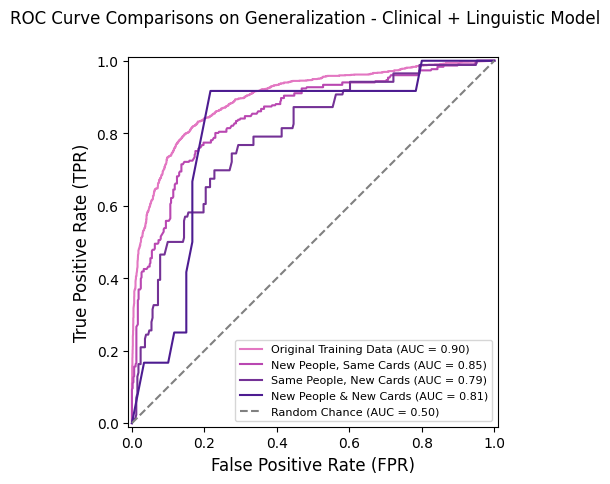

In [ ]:
#Original - Clinical + Linguistic model
clin_ling_disp = RocCurveDisplay.from_estimator(best_rf_clin_ling, X_clin_ling, y, color='tab:pink')
same_cards_disp = RocCurveDisplay.from_estimator(best_rf_clin_ling, X_gen_clin_ling_same_cards, y_gen_clin_ling_same_cards, ax=clin_ling_disp.ax_, color='#b947b1')
same_pts_disp = RocCurveDisplay.from_estimator(best_rf_clin_ling, X_gen_clin_ling_same_pts, y_gen_clin_ling_same_pts, ax=clin_ling_disp.ax_, color='#743296')
all_new_disp = RocCurveDisplay.from_estimator(best_rf_clin_ling, X_gen_clin_ling, y_gen_clin_ling, ax=clin_ling_disp.ax_, color='#4d1c91')

# Add a dashed line for random chance (Null Model)
clin_ling_disp.ax_.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Chance')

# Create custom legend handles
handles, labels = clin_ling_disp.ax_.get_legend_handles_labels()

# Extract AUC from the RocCurveDisplay objects
auc_clin_ling = clin_ling_disp.roc_auc
auc_same_cards = same_cards_disp.roc_auc
auc_same_pts = same_pts_disp.roc_auc
auc_all_new = all_new_disp.roc_auc

# Add the custom legend labels for each curve, including AUC values
labels = [
    f'Original Training Data (AUC = {auc_clin_ling:.2f})',
    f'New People, Same Cards (AUC = {auc_same_cards:.2f})',
    f'Same People, New Cards (AUC = {auc_same_pts:.2f})',
    f'New People & New Cards (AUC = {auc_all_new:.2f})',
    'Random Chance (AUC = 0.50)'
]
# Add the combined legend to the plot
clin_ling_disp.ax_.legend(handles, labels, loc='lower right', prop={'size': 8})

# Change the axis labels
clin_ling_disp.ax_.set_xlabel('False Positive Rate (FPR)', fontsize=12)  # Custom x-axis label
clin_ling_disp.ax_.set_ylabel('True Positive Rate (TPR)', fontsize=12)  # Custom y-axis label

# Add title and other formatting
clin_ling_disp.figure_.suptitle("ROC Curve Comparisons on Generalization - Clinical + Linguistic Model")

# Show the plot
plt.show()

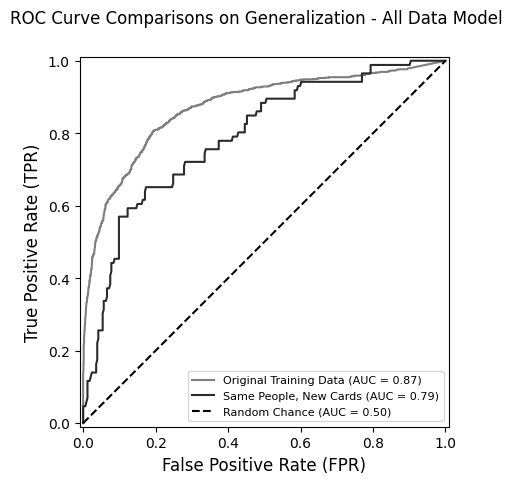

In [ ]:
#All3 model
all3_disp = RocCurveDisplay.from_estimator(best_rf_all3, X_all3, y, color='tab:gray')
same_pts_disp = RocCurveDisplay.from_estimator(best_rf_all3, X_gen_all3_same_pts, y_gen_all3_same_pts, ax=all3_disp.ax_, color='#2b2b2b')

# Add a dashed line for random chance (Null Model)
all3_disp.ax_.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Chance')

# Create custom legend handles
handles, labels = all3_disp.ax_.get_legend_handles_labels()

# Extract AUC from the RocCurveDisplay objects
auc_all3 = all3_disp.roc_auc
auc_same_pts = same_pts_disp.roc_auc

# Add the custom legend labels for each curve, including AUC values
labels = [
    f'Original Training Data (AUC = {auc_all3:.2f})',
    f'Same People, New Cards (AUC = {auc_same_pts:.2f})',
    'Random Chance (AUC = 0.50)'
]
# Add the combined legend to the plot
all3_disp.ax_.legend(handles, labels, loc='lower right', prop={'size': 8})

# Change the axis labels
all3_disp.ax_.set_xlabel('False Positive Rate (FPR)', fontsize=12)  # Custom x-axis label
all3_disp.ax_.set_ylabel('True Positive Rate (TPR)', fontsize=12)  # Custom y-axis label

# Add title and other formatting
all3_disp.figure_.suptitle("ROC Curve Comparisons on Generalization - All Data Model")

# Show the plot
plt.show()

# SHAP & figures for best model(s)

In [ ]:
# Assuming you have your model, explainer, and data ready
shap_values = explainer.shap_values(X_test)

# Calculate mean absolute Shapley values and standard deviations

mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_std = np.abs(shap_values).std(axis=0)

# Create the plot

shap.summary_plot(shap_values, X_test, plot_type="bar", plot_size=(10, 5),
                  show=False)

# Add error bars manually (if needed)
plt.errorbar(range(len(mean_abs_shap)), mean_abs_shap, yerr=shap_std, fmt='o')
plt.xlabel('Features')
plt.ylabel('Mean Absolute Shapley Value')
plt.xticks(range(len(mean_abs_shap)), X_test.columns, rotation=45, ha='right')
plt.show()